
# Predictive Maintenance

1. Imports & Setup
2. Load data
3. EDA
4. Encode categorical variables
5. Normalize numeric columns (Z-score)
6. Train/test split and apply SMOTE (train only)
7. Train Random Forest
8. Evaluation
9. Confusion Matrix
10. Feature Importance
11. Results / Summary

## Imports & setup

In [1]:

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import os
os.makedirs("../figures", exist_ok=True)
os.makedirs("../reports", exist_ok=True)


# Inline plots (if running in classic Jupyter)
%matplotlib inline


##  Load data

In [2]:

# Update the path if needed
csv_path = "../data/predictive_maintenance.csv"
pm = pd.read_csv(csv_path)
pm.head()


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


## EDA

In [3]:
pm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


### Class Distribution


Target
0    9661
1     339
Name: count, dtype: int64 
Class ratio: Target
0    0.966
1    0.034
Name: count, dtype: float64


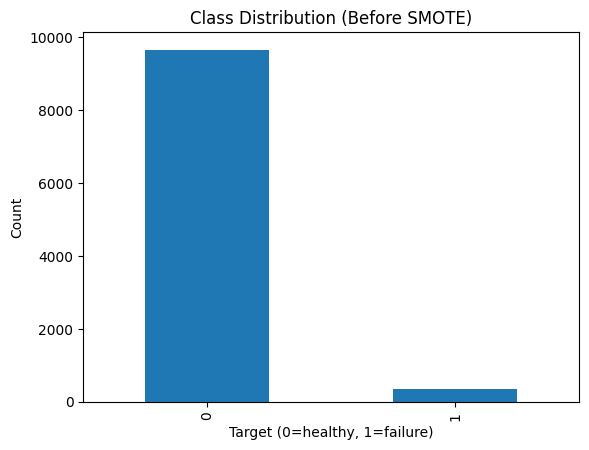

In [4]:
import matplotlib.pyplot as plt

target_counts = pm["Target"].value_counts().sort_index()
print(target_counts, "\nClass ratio:", (target_counts / target_counts.sum()).round(3))

ax = target_counts.plot(kind="bar")
ax.set_title("Class Distribution (Before SMOTE)")
ax.set_xlabel("Target (0=healthy, 1=failure)")
ax.set_ylabel("Count")
plt.savefig("../figures/class_distribution_before_smote.png", dpi=150, bbox_inches='tight')
plt.show()

### Numeric summary

In [5]:
numeric = ['Air temperature [K]', 'Process temperature [K]',
           'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
pm[numeric].describe().T


,count,mean,std,min,25%,50%,75%,max
Air temperature [K],10000.0,300.00493,2.000259,295.3,298.3,300.1,301.5,304.5
Process temperature [K],10000.0,310.00556,1.483734,305.7,308.8,310.1,311.1,313.8
Rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.0,1503.0,1612.0,2886.0
Torque [Nm],10000.0,39.98691,9.968934,3.8,33.2,40.1,46.8,76.6
Tool wear [min],10000.0,107.95100,63.654147,0.0,53.0,108.0,162.0,253.0


### Outliers

In [6]:
import numpy as np
z = (pm[numeric] - pm[numeric].mean())/pm[numeric].std(ddof=0)
(np.abs(z) > 3).sum().sort_values(ascending=False)

Rotational speed [rpm]     164
Torque [Nm]                 25
Air temperature [K]          0
Process temperature [K]      0
Tool wear [min]              0
dtype: int64

### Correlation heatmap

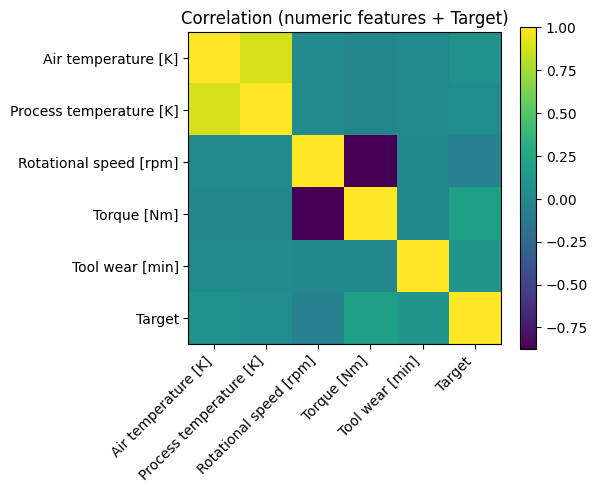

In [7]:
import numpy as np

corr = pm[numeric + ["Target"]].corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(corr.values, interpolation="nearest")
ax.set_xticks(range(len(corr.columns))); ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticks(range(len(corr.index)));   ax.set_yticklabels(corr.index)
fig.colorbar(im, ax=ax)
ax.set_title("Correlation (numeric features + Target)")
plt.savefig("../figures/Correlation_numeric_features_Target).png", dpi=150, bbox_inches='tight')
plt.tight_layout(); plt.show()

##  Encode categorical variables

In [16]:

pm['Failure Type'] = pm['Failure Type'].replace({
    'No Failure': 0,
    'Power Failure': 1,
    'Tool Wear Failure': 2,
    'Overstrain Failure': 3,
    'Heat Dissipation Failure': 4,
    'Random Failures': 5
}).astype(int)

pm['Type'] = pm['Type'].replace({'L': 0, 'M': 1, 'H': 2}).astype(int)
pm.head()


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,1,298.1,308.6,1551,42.8,0,0,0
1,2,L47181,0,298.2,308.7,1408,46.3,3,0,0
2,3,L47182,0,298.1,308.5,1498,49.4,5,0,0
3,4,L47183,0,298.2,308.6,1433,39.5,7,0,0
4,5,L47184,0,298.2,308.7,1408,40.0,9,0,0


##  Normalize numeric columns (Z-score)

In [9]:

pm_cleaned = pm.drop(columns=['UDI', 'Product ID', 'Failure Type'])

for col in ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']:
    pm_cleaned[col] = (pm_cleaned[col] - pm_cleaned[col].mean()) / pm_cleaned[col].std()

pm_cleaned.head()


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,1,-0.952342,-0.947313,0.068182,0.282186,-1.695899,0
1,0,-0.902348,-0.879915,-0.729435,0.633276,-1.648769,0
2,0,-0.952342,-1.014710,-0.227438,0.944242,-1.617349,0
3,0,-0.902348,-0.947313,-0.589992,-0.048843,-1.585930,0
4,0,-0.902348,-0.879915,-0.729435,0.001313,-1.554510,0


##  Train/test split and apply SMOTE (train only)

In [10]:

X = pm_cleaned.drop(columns=['Target'])
y = pm_cleaned['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42, stratify=y
)

# Apply SMOTE on the *training* set only
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

X_train.shape, X_resampled.shape


((6500, 6), (9420, 6))

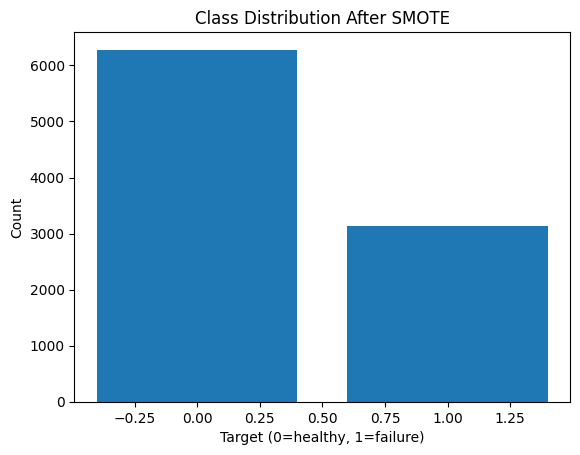

In [11]:
from collections import Counter
import matplotlib.pyplot as plt

# After applying SMOTE:
counts = Counter(y_resampled)
plt.bar(counts.keys(), counts.values())
plt.title("Class Distribution After SMOTE")
plt.xlabel("Target (0=healthy, 1=failure)")
plt.ylabel("Count")
plt.savefig("../figures/Class_Distribution_After_SMOTE.png", dpi=150, bbox_inches='tight')
plt.show()

##  Train Random Forest

In [12]:

clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    random_state=42
)
clf.fit(X_resampled, y_resampled)


RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=200,
                       random_state=42)

##  Evaluation

In [13]:

y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
with open("../reports/classification_report.txt", "w") as f:
    f.write(report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3381
           1       0.59      0.76      0.67       119

    accuracy                           0.97      3500
   macro avg       0.79      0.87      0.83      3500
weighted avg       0.98      0.97      0.98      3500



# Confusion Matrix

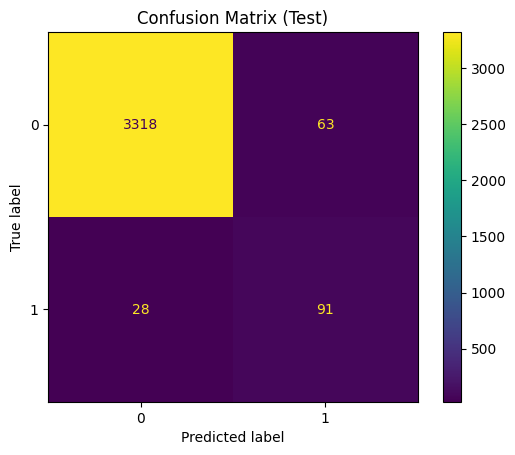

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix (Test)")
plt.savefig("../figures/confusion_matrix.png", dpi=150, bbox_inches='tight')
plt.show()

## Feature importance (model-based)

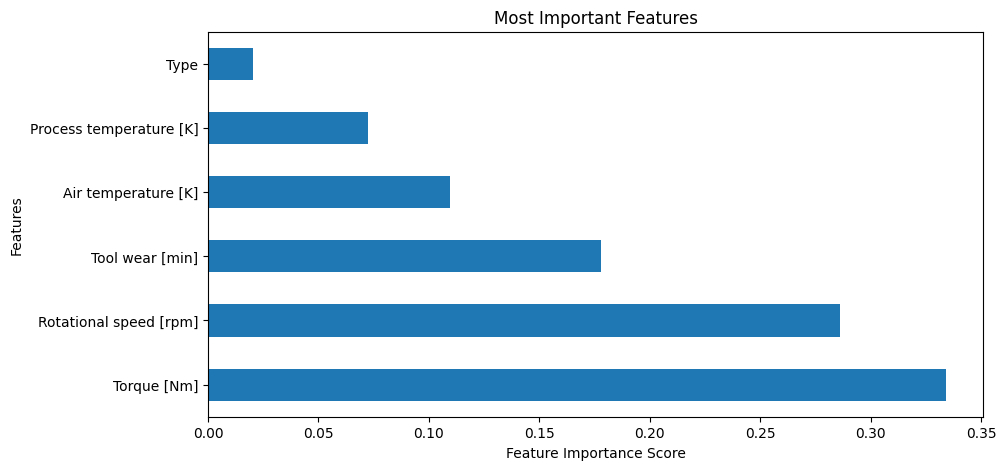

In [15]:

feature_importance = pd.Series(clf.feature_importances_, index=X.columns)
ax = feature_importance.nlargest(10).plot(kind='barh', figsize=(10,5))
ax.set_xlabel("Feature Importance Score")
ax.set_ylabel("Features")
ax.set_title("Most Important Features")
plt.savefig("../figures/Most_Important_Features.png", dpi=150, bbox_inches='tight')
plt.show()



## Results / Summary

- **Dataset:** 10,000 machine records (96.6% healthy, 3.4% failures)
- **Model:** RandomForestClassifier (n_estimators=200, max_depth=15)  
- **Handling imbalance:** SMOTE applied on training set to increase failure examples

### **Test set performance**
- **Weighted Precision:** 0.98  
- **Weighted Recall:** 0.97  
- **Weighted F1-score:** 0.98  
- **Minority class (failures):** Precision 0.59, Recall 0.76, F1-score 0.67  

### **Confusion matrix**
- Correctly classified 91 out of 119 failures (76% recall on minority class)
- Only 28 failures missed, 63 healthy machines falsely flagged

### **Feature insights**
- **Torque** and **Rotational speed** are the strongest predictors of failure